In [48]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## following this https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

In [68]:
tf.reset_default_graph()
batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
# keep_prob will be used when applying dropouts
# it'll be 0.8 during training, and 1 when we're generating new data
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

# Hyper-parameters
dec_in_channels = 1 # decode in 1 channel since it's greyscale
n_latent = 8 # number of Z variables
learning_rate_of_ADAM = 0.0005

# ??
reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.nn.leaky_relu(features = x, alpha=alpha)

In [69]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None): # why?
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1]) #(64, 28, 28, 1)
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(f"conv2d: shape of x: {x.get_shape()}")
        x = tf.nn.dropout(x, keep_prob)
        print(f"dropout: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(f"conv2d: shape of x: {x.get_shape()}")
        x = tf.nn.dropout(x, keep_prob)
        print(f"dropout: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        print(f"conv2d: shape of x: {x.get_shape()}")
        x = tf.nn.dropout(x, keep_prob)
        print(f"dropout: shape of x: {x.get_shape()}")
        # Flattens the input while maintaining the batch_size.
        x = tf.contrib.layers.flatten(x) #(xxx, 1)
        print(f"flatten: shape of x: {x.get_shape()}")
        # for dense(), the second argument `n_latent` is the number of neurons/nodes of the layer
        mn = tf.layers.dense(x, units=n_latent) # (,8)
        print(f"dense: shape of mn: {mn.get_shape()}")
        # unit: dimention of output space
        sd  = 0.5 * tf.layers.dense(x, units=n_latent) #(,8) # why 0.5??
        print(f"dense: shape of sd: {sd.get_shape()}")
        # epsilon ~ N(0,1)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent]), seed = 1218)  #(xxx, 8)
        # why take e^sd instead of sd like in original function?
        z  = mn + tf.multiply(epsilon, tf.exp(sd)) # dimension of this?
        print(f"shape of epsilon: {epsilon.get_shape()}, shape of tf.exp(sd): {tf.exp(sd).get_shape()}")
        print(f"shape of z: {z.get_shape()}")
        
        return z, mn, sd

In [70]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(f"dense: shape of x: {x.get_shape()}")
        x = tf.layers.dense(x, units=inputs_decoder * 2, activation=lrelu) # why inputs_decoder * 2 + 1?
        print(f"dense: shape of x: {x.get_shape()}")
        x = tf.reshape(x, reshaped_dim)
        print(f"reshape: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        print(f"transposed conv2d: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        print(f"transposed conv2d: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(f"transposed conv2d: shape of x: {x.get_shape()}")
        x = tf.contrib.layers.flatten(x)
        print(f"flatten: shape of x: {x.get_shape()}")
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        print(f"dense: shape of x: {x.get_shape()}")
        img = tf.reshape(x, shape=[-1, 28, 28])
        print(f"Img : {img.get_shape()}")
        return img

In [71]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

conv2d: shape of x: (?, 14, 14, 64)
dropout: shape of x: (?, 14, 14, 64)
conv2d: shape of x: (?, 7, 7, 64)
dropout: shape of x: (?, 7, 7, 64)
conv2d: shape of x: (?, 7, 7, 64)
dropout: shape of x: (?, 7, 7, 64)
flatten: shape of x: (?, 3136)
dense: shape of mn: (?, 8)
dense: shape of sd: (?, 8)
shape of epsilon: (?, 8), shape of tf.exp(sd): (?, 8)
shape of z: (?, 8)
dense: shape of x: (?, 24)
dense: shape of x: (?, 49)
reshape: shape of x: (?, 7, 7, 1)
transposed conv2d: shape of x: (?, 14, 14, 64)
transposed conv2d: shape of x: (?, 14, 14, 64)
transposed conv2d: shape of x: (?, 14, 14, 64)
flatten: shape of x: (?, 12544)
dense: shape of x: (?, 784)
Img : (?, 28, 28)


In [72]:
dec.get_shape()

TensorShape([Dimension(None), Dimension(28), Dimension(28)])

In [44]:
# loss function should be image reconstruction loss + KL divergence

In [46]:
# image reconstruction loss, we simply use squared difference
# KL divergence for making sure our latent values will be sampled from a normal distribution
# need to read more: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

In [56]:
# tf.train.AdamOptimizer

In [73]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1) # ??
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(learning_rate_of_ADAM).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [65]:
?? mnist.train.next_batch

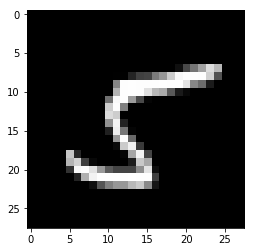

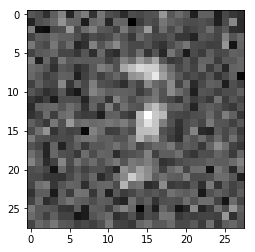

0 178.31784 178.31302 0.004821129


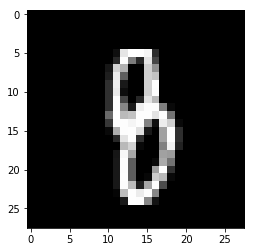

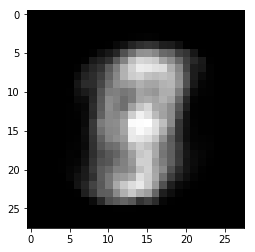

200 48.501637 46.843357 1.6582811


In [ ]:
# training
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

In [ ]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')